<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/Experiments/MNIST_Step%204_%20Fully%20Connected%20layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Increase model capacity at the end (add layer after GAP)

## Results:
- Parameters: 6,124
- Best Training Accuracy: 99.07
- Best Test Accuracy: 99.22

## Analysis:
- The model parameters have increased
- There is no overfitting rather slight underfitting, thats fine dropout is doing its work , because we are adding dropout at each layer the model is able to capture the training accuracy
- However, we haven't reached 99.4 accuracy yet.
- Observing the missclassified images its good to try out some augmentation techniques as few images seems to be slightly rotated, and also image contrast needs to be considered

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm import tqdm
from torchsummary import summary

# for visualization
%matplotlib inline
import matplotlib.pyplot as plt

from model import Model_5, download_model_data, create_data_loader, train_and_predict
from utils import get_device, plot_metrics

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

Data tasks:
- transformers
- data download
- train and test split

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

ds_train, ds_test = download_model_data()
# dataloader arguments - something you'll fetch these from cmdprmt
kw_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# train dataloader
train_loader = torch.utils.data.DataLoader(ds_train, **kw_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(ds_test, **kw_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = ds_train.train_data
train_data = ds_train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', ds_train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', ds_train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# visualize
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

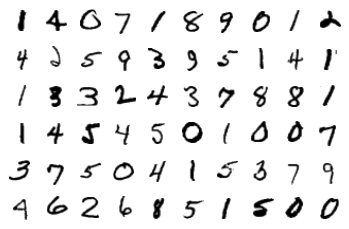

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Add batch normalization, no matter how complex is the data batch normalization can handle that. Batch norm fixes the problems with high contrast and low contract issues with the images.

Batch normaliztion maintains and stores a specific mean and std deviation for each layer, because it has to normlize it and untilmately it has to learn how to normalize the particular layer evntually even during the inference,  so there is a increase in the number of parameters after batch norm

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
# get the device and load the model
device = get_device()
print(device)
model = Model_5().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

### Train and test our model

In [ ]:
train_losses5 = []
test_losses5 = []
train_acc5 = []
test_acc5 = []

model =  Model_5().to(device)
epochs = 15
train_losses5, train_acc5, test_losses5, test_acc5 = train_and_predict(model, device,
                                                                   train_loader=train_loader,
                                                                   test_loader=test_loader, 
                                                                   num_epochs=epochs, lr=0.01)

We start at 93.57%, the model has started behaving very well in the first few batches itself , so the training accuracy in first batch is good.

### Plot the train and test losses and accuracies for Model_5

In [ ]:
plot_metrics(train_losses5, train_acc5, test_losses5, test_acc5)

### Incorrect Predictions

In [12]:
def extract_incorrect_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])   

  return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [13]:
incorrect_predictions = extract_incorrect_predictions(test_loader,model,device)

In [14]:
print(f'Total incorrect predictions are {len(incorrect_predictions)}')

Total wrong predictions are 78


In [ ]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(incorrect_predictions[:50]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()